In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

# 1. Data preparing

**Machine Learning** has two parts :
1. convert the data into numerical format
2. learn patterns and fit the model from the numerical format

The simplest form of linear function is `Y = ax+b`\\
where `a` is the weight and `b` is the bias. \\
both `a` and `b` are know as **The Parameters** of the model, and the goal is to minimize them by using **optemizer**

In [ ]:
# Creating simple linear function with 'know' parameters
weight = 0.7
bias = 0.3
X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias
X.shape , y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [ ]:
X[:5], y[:5] # view the first 5 numbers

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

## Split the data into training and testing sets

In [ ]:
training_size = int(0.8 * len(X)) # 80% of the size of X
X_train , y_train = X[:training_size], y[:training_size] # training sets
X_test, y_test = X[training_size:], y[training_size:] # testing sets
print(f"We have {len(X_train)} training examples and {len(X_test)} testing examples")

We have 40 training examples and 10 testing examples


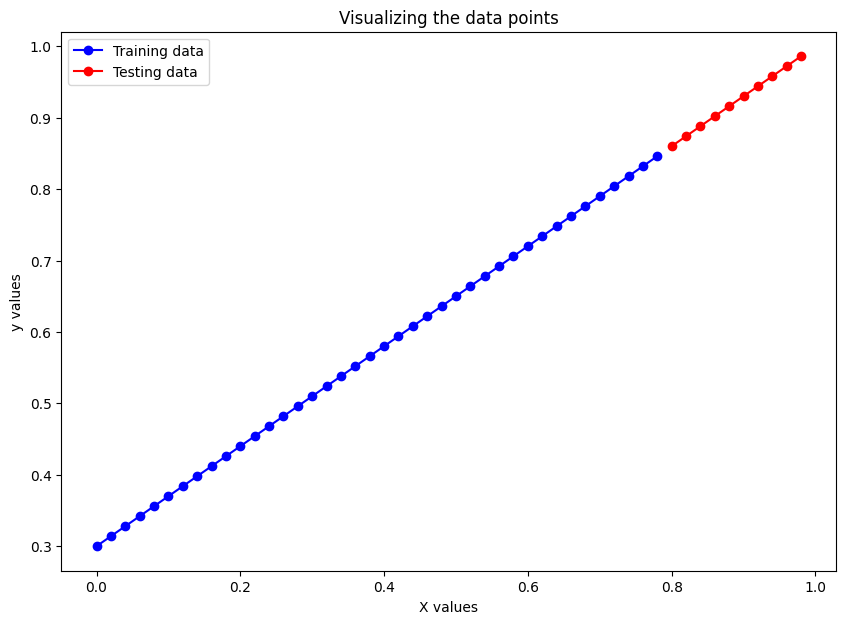

In [ ]:
# visualize the data points
def plot_predections(train_data=X_train,train_labels=y_train,
                     test_data=X_test,test_labels=y_test,
                     predections = None):
  plt.figure(figsize=(10,7))
  plt.plot(train_data,train_labels, color='blue', marker='o', label='Training data')
  plt.plot(test_data, test_labels, color='red', marker='o', label='Testing data')
  plt.xlabel('X values')
  plt.ylabel('y values')
  plt.title('Visualizing the data points')
  if predections is not None :
    plt.plot(test_data, predections, color='green', marker='x', label='Predections')
  plt.legend()
  plt.show()
plot_predections()

# 2. Build a model

In [ ]:
# Create linear regression model class
import torch
from torch import nn
torch.manual_seed(42)

# class LinearRegressionModel(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.weights = nn.Parameter(torch.randn(1,requires_grad=True, dtype = torch.float))
#     self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

#   def forward(self, x : torch.Tensor) -> torch.Tensor:
#     return self.weights * x + self.bias

In [ ]:
model_0 = LinearRegressionModel()

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make Predections

we will make predections on the data X_test to get y_hat using `torch.inference_mode()` this method will take the x values and perform the forward() method inside our model

* inference_mode() will disable the grad tracking of tensors to make the learning process faster

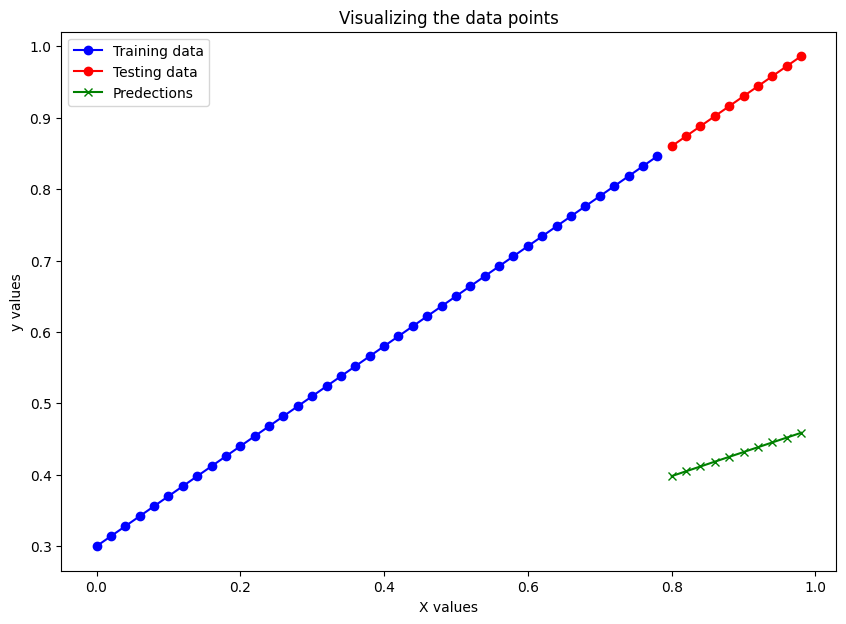

In [ ]:
with torch.inference_mode():
  y_pred = model_0(X_test)
# test the accuracy of our model with the initially random parameters
plot_predections(predections=y_pred)

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are:

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).

Woah, that's a lot, let's see it in code.

In [ ]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.001)

### Building a training loop (and a testing loop) in PyTorch

0. Loop through the data.
1. Forward pass use `forward()` to make some predections
2. Calculate the loss.
3. Optimizer zero grad.
4. Loss backward.
5. Optimizer step

In [ ]:
torch.manual_seed(42)

epochs = 2000 # number of iterations

# keep track of the values and plot them
epoch_count = []
loss_values = []
test_loss_values = []
# Training process

# 0. Loop through the data
for epoch in range(epochs):
  # set the model on training mode
  model_0.train() # sets all parameters that requier gradinats to True

  # 1. Forward pass
  y_pred = model_0(X_train) # we make predections using `forward()` for the training data

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train) # calculate the loss using MAE with(y_pred,y_true)
  #print(f'The loss {loss}')

  #. 3. Optimizer zero grad
  optimizer.zero_grad() # by default the optimizer will accumulate the steps each loop so we set it to zero at each iteration

  # 4. Loss backward
  loss.backward() # perform backpropagation with respect to the model's parameters

  # 5. Optimizer step ''' Gradina Descent'''
  optimizer.step() # take one step to mimnize the loss function of our model's parameters


  # Testing
  model_0.eval() # set turns off settings not needed for evaluations (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradiant tracking and couple more things behinde the scenes
    y_hat = model_0(X_test) # run forward to make predections for the tesing set
    test_loss = loss_fn(y_hat, y_test) # calculate the loss for the testing data set

  # print some tracking results
  if epoch % 100 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss {loss} | Test loss {test_loss}")


Epoch: 0 | Loss 0.31288138031959534 | Test loss 0.4931890368461609
Epoch: 100 | Loss 0.19767141342163086 | Test loss 0.35847947001457214
Epoch: 200 | Loss 0.08973254263401031 | Test loss 0.22795839607715607
Epoch: 300 | Loss 0.05357731133699417 | Test loss 0.15086300671100616
Epoch: 400 | Loss 0.04549176245927811 | Test loss 0.11657620966434479
Epoch: 500 | Loss 0.04160415381193161 | Test loss 0.10088418424129486
Epoch: 600 | Loss 0.03811401128768921 | Test loss 0.08986451476812363
Epoch: 700 | Loss 0.03466346859931946 | Test loss 0.08097299933433533
Epoch: 800 | Loss 0.03122851625084877 | Test loss 0.07297395914793015
Epoch: 900 | Loss 0.027794325724244118 | Test loss 0.06490625441074371
Epoch: 1000 | Loss 0.02435956709086895 | Test loss 0.05690721794962883
Epoch: 1100 | Loss 0.02092517353594303 | Test loss 0.0488395169377327
Epoch: 1200 | Loss 0.017490629106760025 | Test loss 0.04084048420190811
Epoch: 1300 | Loss 0.014056024141609669 | Test loss 0.03277278691530228
Epoch: 1400 | Los

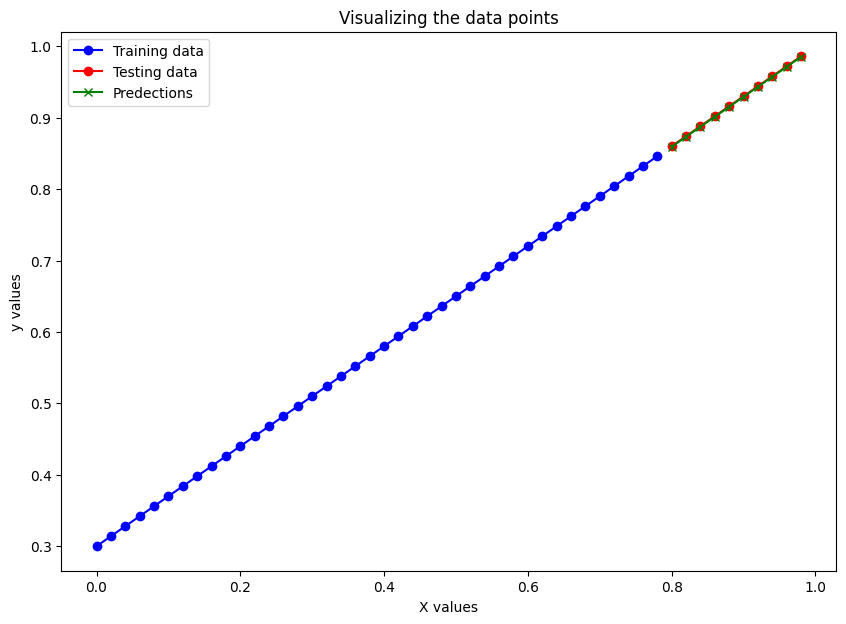

In [ ]:
with torch.inference_mode():
  y_hat = model_0(X_test)
plot_predections(predections=y_hat)

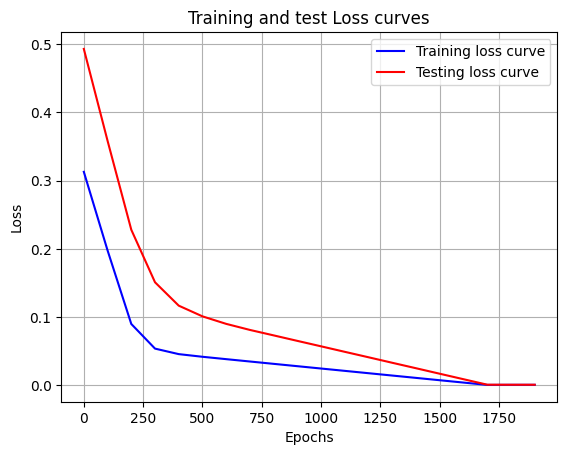

In [ ]:
plt.plot(epoch_count, torch.tensor(loss_values).cpu().numpy(), color='blue', label='Training loss curve')
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), color='red', label='Testing loss curve')
plt.title('Training and test Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### Saving a module

In [ ]:
from pathlib import Path

# 1. Create a module directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model saved path
MODEL_NAME = "First_Linear_model.pth" # pt or pth are commons file extesntion for torch objects
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # the path and the name of the file 'models/First_Linear_model.pth'
print(MODEL_SAVE_PATH)
# 3. Saving the module dict state
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) # you can simply write f='models/First_Linear_model.pth'



models/First_Linear_model.pth


### Load a model

In [ ]:
loaded_model_0 = LinearRegressionModel() # create new object from the same class of our saved model
print(f"The state dict keys of our model befor loading {loaded_model_0.state_dict()}")
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH,weights_only=True)) # load the state dict of the saved model
print(f"The state dict keys of our model after loading {loaded_model_0.state_dict()}")

The state dict keys of our model befor loading OrderedDict([('weights', tensor([-1.1229])), ('bias', tensor([-0.1863]))])
The state dict keys of our model after loading OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])


# Put Everything together and build the model from scratch

In [ ]:

# import the libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

# Create a Linear model class
class LinearRegressionModel(nn.Module):
  # define the constructor and the module parameters
  def __init__(self):
    super().__init__()
    # we can use self.linear_layer = nn.linear(in_features=*, out_features=*)
    weights = torch.randn(1, requires_grad=True, dtype=torch.float)
    bias = torch.randn(1, requires_grad=True, dtype=torch.float)
    self.weight = nn.Parameter(weights)
    self.bias = nn.Parameter(bias)

  # define the forward function of the model to learn and predict based on it
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Y = AX + B
    return self.weight * x + self.bias

  def fit(self, X_train,y_train,X_test,y_test,epochs=1000,learning_rate=0.01,Print_values=False):
    # 1. define a loss function
    loss_fn = nn.L1Loss()
    # 2. define an optimizer
    optimizer = torch.optim.SGD(params=self.parameters(), lr = learning_rate)

    # 3. manula seed
    torch.manual_seed(42)

    # 4. create the training loop
    epoch_count = []
    loss_values = []
    test_loss_values = []
    for epoch in range(epochs):
      self.train() # set the model on the training mode

      y_pred = self.forward(X_train) # make predections

      loss = loss_fn(y_pred, y_train) # calcluate the loss function 'MAE'

      optimizer.zero_grad() # set the gradiant step to zero at each iteration to prevent accumlation of the value

      loss.backward() # calculate the backpropagation step to minimize the loss function

      optimizer.step() # take one step to minimize the loss function

      # Testing
      self.eval() # set the model to eval for faster evaluating and testing
      with torch.inference_mode():
        y_hat = self.forward(X_test)
        test_loss = loss_fn(y_hat,y_test)

      # save the values 'optional' to print and plot them
      if Print_values and epoch % 100 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss {loss} | Test loss {test_loss}")

    if Print_values:
      plt.plot(epoch_count, torch.tensor(loss_values).cpu().numpy(), color='blue', label='Training loss curve')
      plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), color='red', label='Testing loss curve')
      plt.title('view the loss curve behavior')
      plt.legend()
      plt.grid(True)
      plt.show()


  def predict(self,X_data):
    y_hat = self.forward(X_data) # make predections
    return y_hat

  def plot_predections(self,X_train,y_tarin,X_test,y_test, predections=None):
    plt.figure(figsize=(10,8))
    plt.plot(X_train, y_train, color='blue', marker='o', label='Training data')
    plt.plot(X_test, y_test, color='red', marker='o', label='Testing data')
    plt.xlabel('X values')
    plt.ylabel('y values')
    if predections is not None :
      plt.plot(X_test, predections, color='green', marker='x',label='predections')
      plt.title("Visualizing the predections")
    plt.legend()
    plt.show()

  def train_test_split(self,X_data,y_data,train_size=0.8):
    train_data = int(train_size * len(X_data))
    X_train, y_train = X_data[:train_data], y_data[:train_data]
    X_test, y_test = X_data[train_data: ], y_data[train_data:]
    return X_train, X_test, y_train , y_test




# Test out build class model

In [ ]:
weight = 3.9
bias = 0.8
X = torch.arange(0,1,0.01).unsqueeze(dim=1)
y = weight * X + bias
X[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.8000],
         [0.8390],
         [0.8780],
         [0.9170],
         [0.9560]]))

In [ ]:
my_model = LinearRegressionModel() # create the model

In [ ]:
X_train, X_test, y_train, y_test = my_model.train_test_split(X,y) # split the data
print(f'We have {len(X_train)} Training examples and {len(X_test)} Testing examples')

We have 80 Training examples and 20 Testing examples


In [ ]:
my_model.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

Epoch: 0 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 100 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 200 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 300 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 400 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 500 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 600 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 700 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 800 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 900 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 1000 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 1100 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 1200 | Loss 0.008336735889315605 | Test loss 0.006970501039177179
Epoch: 1300 | Loss 0.008336735889315605 | Test loss 0.006970501

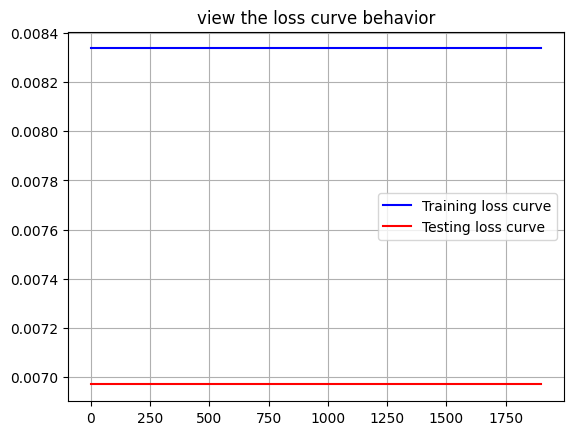

In [ ]:
# fit the model
my_model.fit(X_train,y_train,X_test,y_test,epochs=2000,Print_values=True)

In [ ]:
my_model.state_dict()

OrderedDict([('weight', tensor([3.8965])), ('bias', tensor([0.8097]))])

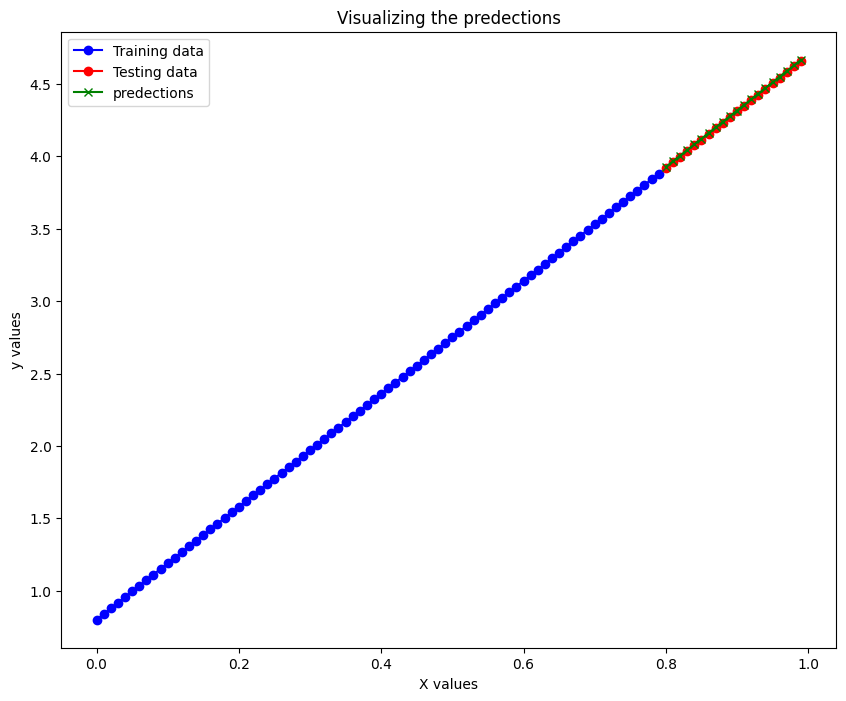

In [ ]:
y_pred = my_model.predict(X_test).cpu().detach().numpy()
my_model.plot_predections(X_train,y_train,X_test,y_test,predections=y_pred)

## Using nn.Linear for creating out module's parameters

In [ ]:
import torch
from torch import nn

class LinearRegression(nn.Module):
  def __init__(self,in_features=1,out_features=1):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=in_features,out_features=out_features) # only one line to create random starting parameters for out model with any number of input and output features

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [ ]:
model_1 = LinearRegression(10,2)
model_1.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[ 0.0592,  0.2336,  0.0428,  0.1525, -0.0446,  0.2438,  0.0467, -0.1476,
                        0.0806, -0.1457],
                      [-0.0371, -0.1284,  0.2098, -0.2496, -0.1458, -0.0893, -0.1901,  0.0298,
                       -0.3123,  0.2856]])),
             ('linear_layer.bias', tensor([-0.2686,  0.2441]))])

In [ ]:
list(model_1.parameters())

[Parameter containing:
 tensor([[ 0.0592,  0.2336,  0.0428,  0.1525, -0.0446,  0.2438,  0.0467, -0.1476,
           0.0806, -0.1457],
         [-0.0371, -0.1284,  0.2098, -0.2496, -0.1458, -0.0893, -0.1901,  0.0298,
          -0.3123,  0.2856]], requires_grad=True),
 Parameter containing:
 tensor([-0.2686,  0.2441], requires_grad=True)]